# Test pickle

In [16]:
import pickle

In [17]:
with open('libs/datasets/1000_tictactoe_temperature_1.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [18]:
len(dataset)

7082

In [19]:
dataset[0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.1 , 0.1 , 0.1 , 0.12, 0.12, 0.12, 0.12, 0.12, 0.1 ]),
 -1)

In [20]:
import tensorflow as tf

In [21]:
boards, estimated_pis, estimated_vs = list(zip(*dataset))

boards = tf.concat([b[np.newaxis, :] for b in boards], axis=0)
estimated_pis = tf.concat([p[np.newaxis, :] for p in estimated_pis], axis=0)

estimated_pis = tf.cast(estimated_pis, dtype=tf.float32)
estimated_vs = tf.constant(estimated_vs, dtype=tf.float32)

In [22]:
boards

<tf.Tensor: shape=(7082, 9), dtype=float64, numpy=
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ..., -0., -0., -1.],
       [ 0.,  0., -1., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [-0., -0., -0., ..., -0., -1., -1.],
       [ 0., -1.,  0., ...,  0.,  1.,  1.]])>

In [23]:
estimated_pis

<tf.Tensor: shape=(7082, 9), dtype=float32, numpy=
array([[0.1       , 0.1       , 0.1       , ..., 0.12      , 0.12      ,
        0.1       ],
       [0.12962963, 0.12962963, 0.12962963, ..., 0.12962963, 0.12962963,
        0.        ],
       [0.14285715, 0.14285715, 0.        , ..., 0.14285715, 0.14285715,
        0.        ],
       ...,
       [0.12068965, 0.12068965, 0.12068965, ..., 0.10344828, 0.        ,
        0.5344828 ],
       [0.225     , 0.225     , 0.275     , ..., 0.275     , 0.        ,
        0.        ],
       [0.02985075, 0.        , 0.49253732, ..., 0.47761193, 0.        ,
        0.        ]], dtype=float32)>

In [24]:
estimated_vs

<tf.Tensor: shape=(7082,), dtype=float32, numpy=array([-1.,  1., -1., ...,  1., -1.,  1.], dtype=float32)>

In [144]:
BATCH_SIZE = 20
tf_dataset = tf.data.Dataset.from_tensor_slices((boards,(estimated_pis,estimated_vs))).shuffle(100).batch(BATCH_SIZE)

In [146]:
test_dataset = tf_dataset.take(1000) 
train_dataset = tf_dataset.skip(1000)

In [11]:
class AZLoss(tf.keras.losses.Loss):
    
    def __init__(self):
        super().__init__('auto')
        self.p_loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.v_loss_fn = tf.keras.losses.MeanSquaredError()

    def call(self, y_true, y_pred):
        
        estimated_pis, estimated_vs = y_true
        predicted_pis, predicted_vs = y_pred
        
        p_losses = self.p_loss_fn(estimated_pis, predicted_pis)
        v_losses = self.v_loss_fn(predicted_vs, estimated_vs)
        
        return p_losses + v_losses

In [25]:
tf.keras.losses.CategoricalCrossentropy()( estimated_pis, estimated_pis )

<tf.Tensor: shape=(), dtype=float32, numpy=1.3827641>

# Test MCTS

In [1]:
import numpy as np
from libs.TicTacToe import TicTacToe
from libs.model import create_model
from libs.MCTS import MCTS

In [19]:
mcts = MCTS(game=TicTacToe(), n_simulations=20)

In [20]:
state = np.array([0., 0., -1., -1., 1., -1., 1., 1., 0.])

In [21]:
root = mcts.run(model=create_model(), state=state, player=1)

In [22]:
root

State:
[ 0.  0. -1. -1.  1. -1.  1.  1.  0.]
Player:1
Value:0.95
Leaf:False
Visits:20
Children:
 -0: prior=0.3333333333333333
 -1: prior=0.3333333333333333
 -8: prior=0.3333333333333333

In [23]:
root.children

{0: State:
 [ 1.  0. -1. -1.  1. -1.  1.  1.  0.]
 Player:-1
 Value:0.0
 Leaf:False
 Visits:1
 Children:
  -1: prior=0.5
  -8: prior=0.5,
 1: State:
 [ 0.  1. -1. -1.  1. -1.  1.  1.  0.]
 Player:-1
 Value:-1.0
 Leaf:True
 Visits:9
 Children:,
 8: State:
 [ 0.  0. -1. -1.  1. -1.  1.  1.  1.]
 Player:-1
 Value:-1.0
 Leaf:True
 Visits:10
 Children:}

In [24]:
root.children[0]

State:
[ 1.  0. -1. -1.  1. -1.  1.  1.  0.]
Player:-1
Value:0.0
Leaf:False
Visits:1
Children:
 -1: prior=0.5
 -8: prior=0.5

In [25]:
state = np.array([0., 0., 0., 0., 0., 0., 0., -1., 0.])

In [26]:
root = mcts.run(model=create_model(), state=state, player=-1)

In [27]:
root

State:
[-0. -0. -0. -0. -0. -0. -0.  1. -0.]
Player:-1
Value:0.0
Leaf:False
Visits:20
Children:
 -0: prior=0.125
 -1: prior=0.125
 -2: prior=0.125
 -3: prior=0.125
 -4: prior=0.125
 -5: prior=0.125
 -6: prior=0.125
 -8: prior=0.125

In [28]:
root.children

{0: State:
 [-1. -0. -0. -0. -0. -0. -0.  1. -0.]
 Player:1
 Value:0.0
 Leaf:False
 Visits:3
 Children:
  -1: prior=0.14285714285714285
  -2: prior=0.14285714285714285
  -3: prior=0.14285714285714285
  -4: prior=0.14285714285714285
  -5: prior=0.14285714285714285
  -6: prior=0.14285714285714285
  -8: prior=0.14285714285714285,
 1: State:
 [-0. -1. -0. -0. -0. -0. -0.  1. -0.]
 Player:1
 Value:0.0
 Leaf:False
 Visits:2
 Children:
  -0: prior=0.14285714285714285
  -2: prior=0.14285714285714285
  -3: prior=0.14285714285714285
  -4: prior=0.14285714285714285
  -5: prior=0.14285714285714285
  -6: prior=0.14285714285714285
  -8: prior=0.14285714285714285,
 2: State:
 [-0. -0. -1. -0. -0. -0. -0.  1. -0.]
 Player:1
 Value:0.0
 Leaf:False
 Visits:3
 Children:
  -0: prior=0.14285714285714285
  -1: prior=0.14285714285714285
  -3: prior=0.14285714285714285
  -4: prior=0.14285714285714285
  -5: prior=0.14285714285714285
  -6: prior=0.14285714285714285
  -8: prior=0.14285714285714285,
 3: State:
 [

In [31]:
root_children8 = mcts.run(model=create_model(), state=root.children[8].state, player=-1, root=root.children[8])

In [32]:
root_children8

State:
[-0. -0. -0. -0. -0. -0. -0.  1. -1.]
Player:1
Value:0.0
Leaf:False
Visits:22
Children:
 -0: prior=0.14285714285714285
 -1: prior=0.14285714285714285
 -2: prior=0.14285714285714285
 -3: prior=0.14285714285714285
 -4: prior=0.14285714285714285
 -5: prior=0.14285714285714285
 -6: prior=0.14285714285714285

In [33]:
root_children8.children

{0: State:
 [ 1. -0. -0. -0. -0. -0. -0.  1. -1.]
 Player:-1
 Value:0.0
 Leaf:False
 Visits:3
 Children:
  -1: prior=0.16666666666666666
  -2: prior=0.16666666666666666
  -3: prior=0.16666666666666666
  -4: prior=0.16666666666666666
  -5: prior=0.16666666666666666
  -6: prior=0.16666666666666666,
 1: State:
 [-0.  1. -0. -0. -0. -0. -0.  1. -1.]
 Player:-1
 Value:0.0
 Leaf:False
 Visits:3
 Children:
  -0: prior=0.16666666666666666
  -2: prior=0.16666666666666666
  -3: prior=0.16666666666666666
  -4: prior=0.16666666666666666
  -5: prior=0.16666666666666666
  -6: prior=0.16666666666666666,
 2: State:
 [-0. -0.  1. -0. -0. -0. -0.  1. -1.]
 Player:-1
 Value:0.0
 Leaf:False
 Visits:3
 Children:
  -0: prior=0.16666666666666666
  -1: prior=0.16666666666666666
  -3: prior=0.16666666666666666
  -4: prior=0.16666666666666666
  -5: prior=0.16666666666666666
  -6: prior=0.16666666666666666,
 3: State:
 [-0. -0. -0.  1. -0. -0. -0.  1. -1.]
 Player:-1
 Value:0.0
 Leaf:False
 Visits:3
 Children:
 

# Test Model

In [4]:
import numpy as np
import tensorflow as tf

In [5]:
tf.one_hot(tf.cast(np.array([[0., 0., -1., 0., 0., 0., 0., -1., 1.]])+1, tf.int32),3)

<tf.Tensor: shape=(1, 9, 3), dtype=float32, numpy=
array([[[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]]], dtype=float32)>

In [38]:
def create_az_model():

    kernel_regularizer = tf.keras.regularizers.L2(0.001)

    inputs = tf.keras.layers.Input((9))

    # One-Hot encoding
    print(tf.shape(inputs))
    x = tf.cast(tf.one_hot(tf.cast(inputs + 1, tf.int32), 3), tf.float32)
    print(tf.shape(x))
    
    # Residual tower NN
    x = tf.reshape(x, (-1, 3, 3, 3))
    x = tf.keras.layers.Conv2D(
        filters=3**6, kernel_size=(3, 3), kernel_regularizer=kernel_regularizer
    )(x)
    print(tf.shape(x))
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(
        filters=3**4, kernel_size=1, kernel_regularizer=kernel_regularizer
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    flatten_inputs = tf.keras.layers.Flatten()(inputs)
    x = tf.concat([flatten_inputs, x], axis=1)
    residual_tower = tf.keras.layers.ReLU()(x)

    # Policy NN
    x = tf.keras.layers.Conv1D(
        filters=2, kernel_size=1, kernel_regularizer=kernel_regularizer
    )(residual_tower[..., np.newaxis])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    p = tf.keras.layers.Dense(
        9,
        activation=tf.keras.activations.softmax,
        kernel_regularizer=kernel_regularizer,
    )(x)

    # Value NN
    x = tf.keras.layers.Conv1D(
        filters=1, kernel_size=1, kernel_regularizer=kernel_regularizer
    )(residual_tower[..., np.newaxis])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        256,
        activation=tf.keras.activations.relu,
        kernel_regularizer=kernel_regularizer,
    )(x)
    v = tf.keras.layers.Dense(
        1, activation=tf.nn.tanh, kernel_regularizer=kernel_regularizer
    )(x)

    outputs = p, v

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="tictactoe_model")

    zero_weights = []
    for arr in model.get_weights():
        zero_weights.append(np.zeros(arr.shape))
    model.set_weights(zero_weights)

    return model


In [40]:
model = create_az_model()

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 9], name='tf.compat.v1.shape_12/Shape:0', description="created by layer 'tf.compat.v1.shape_12'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 9, 3], name='tf.compat.v1.shape_13/Shape:0', description="created by layer 'tf.compat.v1.shape_13'")
KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 1, 1, 729], name='tf.compat.v1.shape_14/Shape:0', description="created by layer 'tf.compat.v1.shape_14'")


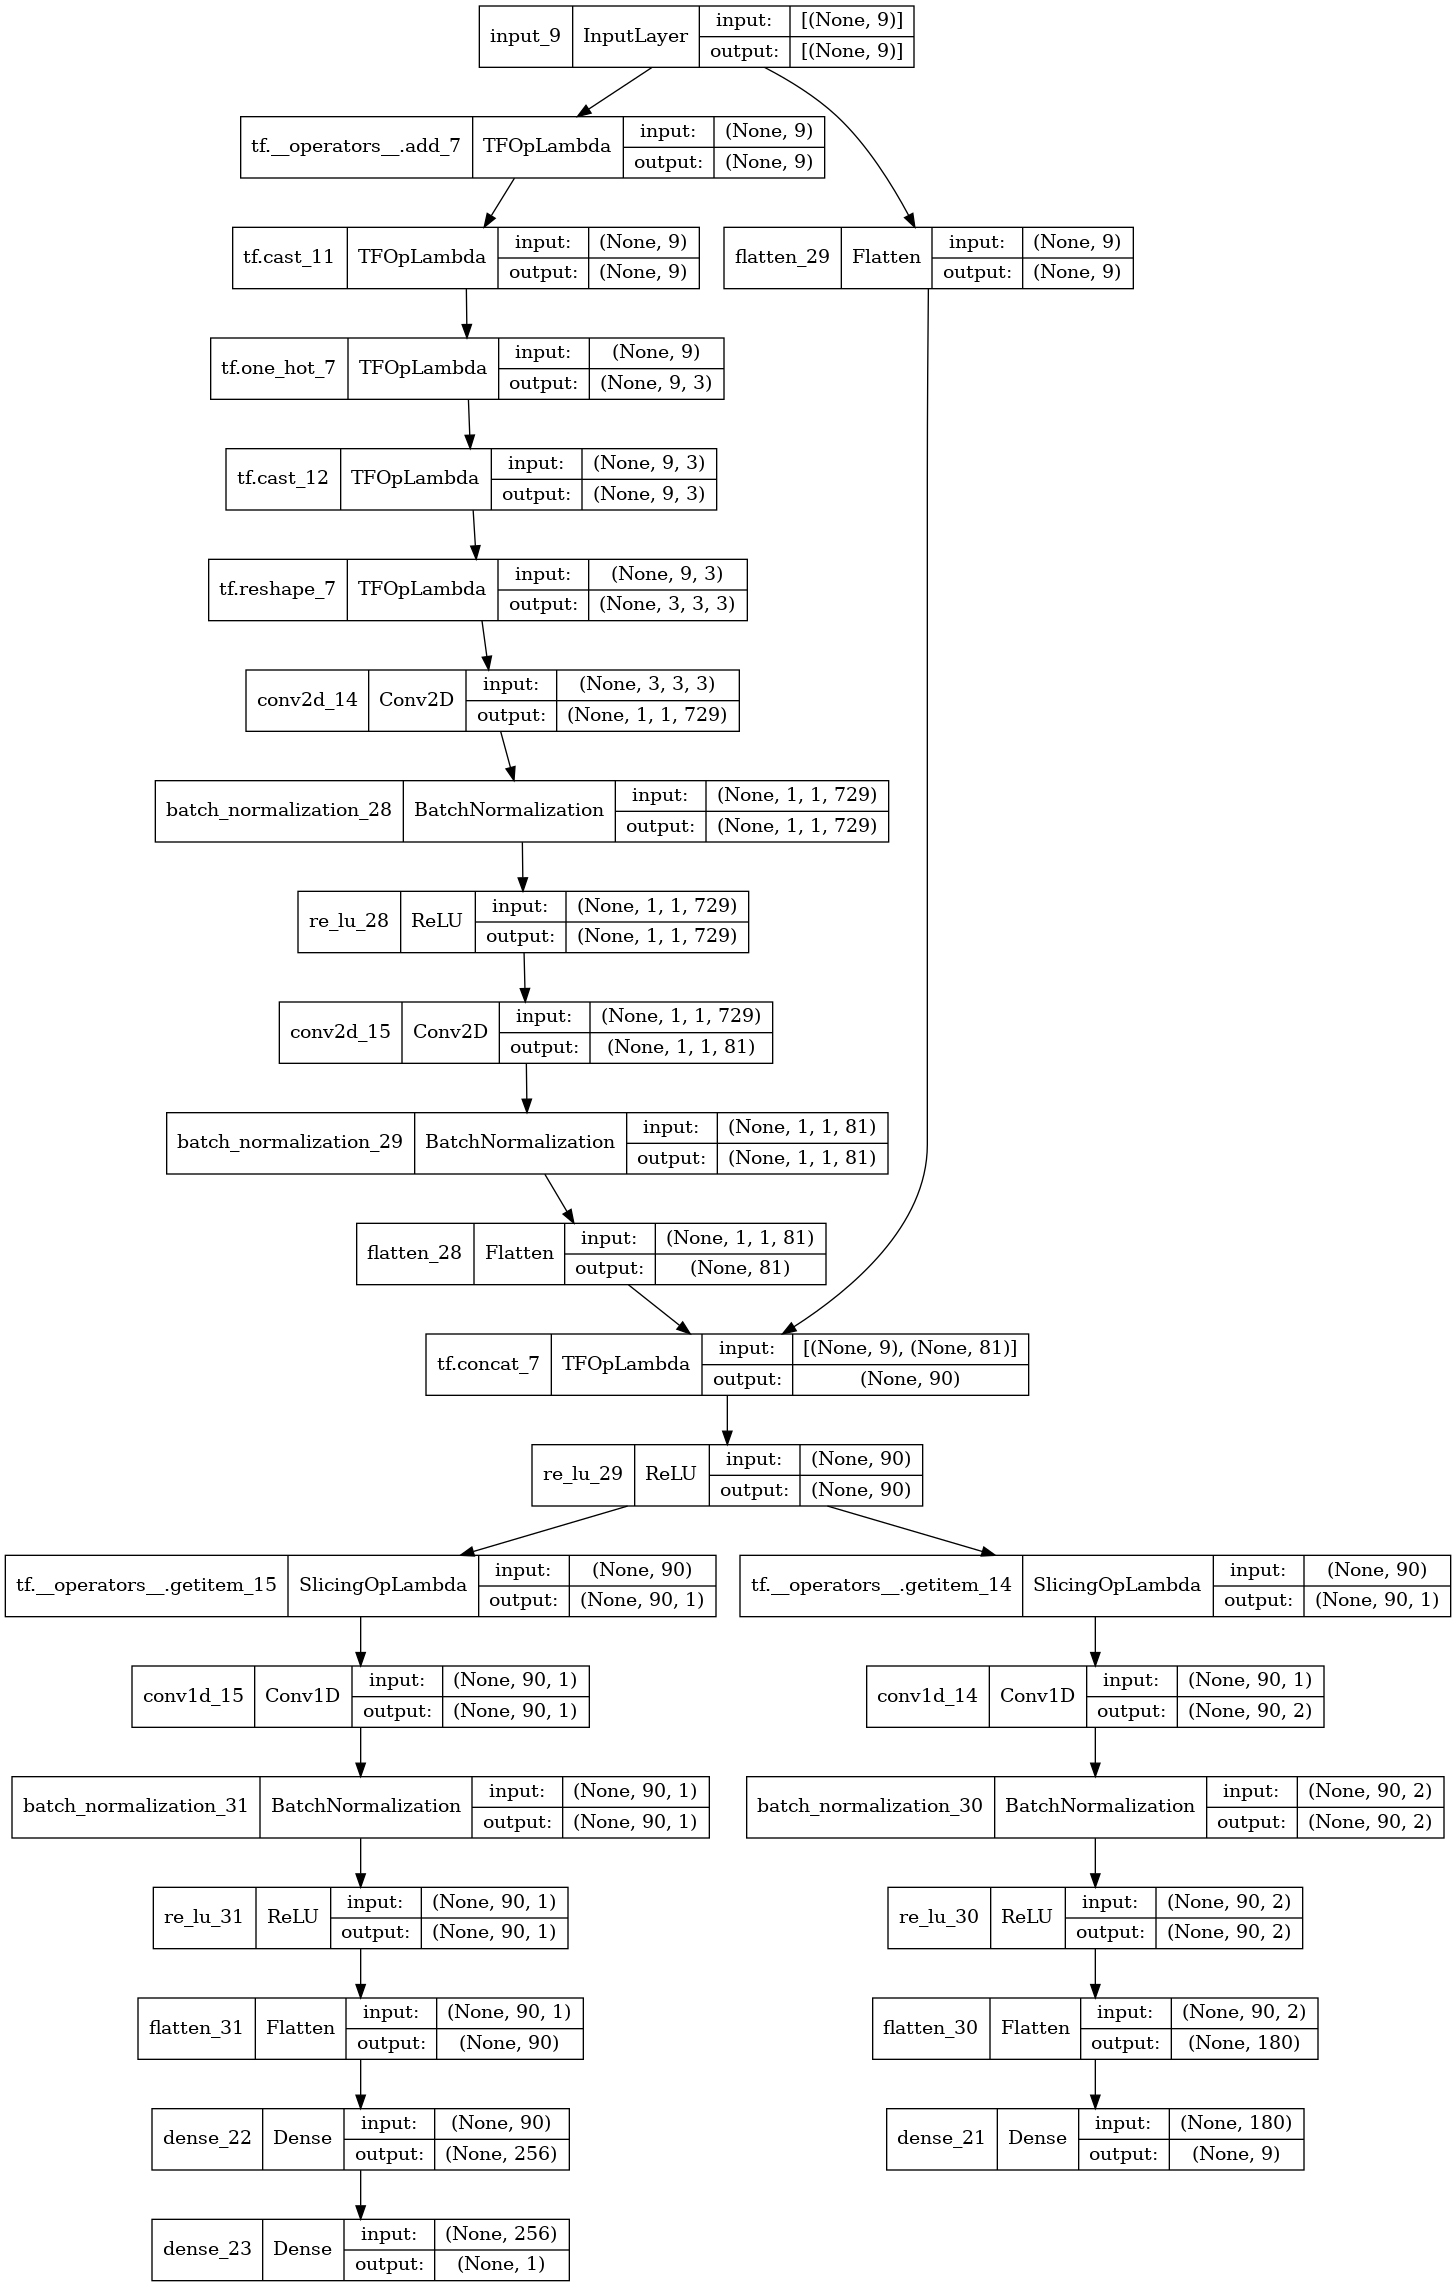

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "tictactoe_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 9)           0           ['input_1[0][0]']                
 da)                                                                                              
                                                                                                  
 tf.cast (TFOpLambda)           (None, 9)            0           ['tf.__operators__.add[0][0]']   
                                                                                                  
 tf.one_hot (TFOpLambda)        (None, 9, 3)         0           ['tf.cast[0][0]']  

In [109]:
test_input = np.array([[0., 0., 0., 0., 0., 0., 0., -1., 0.],[1., -1., 0., 0., 0., 0., 0., -1., 0.]])

In [110]:
model(test_input)

(<tf.Tensor: shape=(2, 9), dtype=float32, numpy=
 array([[0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
         0.11111111, 0.11111111, 0.11111111, 0.11111111],
        [0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
         0.11111111, 0.11111111, 0.11111111, 0.11111111]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.02214767],
        [-0.11242329]], dtype=float32)>)

In [114]:
loss = tf.keras.losses.CategoricalCrossentropy()

In [116]:
loss([0.1, 0.7, 0.5, 0.5, 0., 0., 0., 0.1, 0.],[0.1, 0.7, 0.5, 0.6, 0., 0., 0., 0.0, 0.])

<tf.Tensor: shape=(), dtype=float32, numpy=3.849064>